In [2]:
# Step 1: Import libraries
import pandas as pd
import numpy as np

# Step 2: Load the CSV data
file_path = 'RunningData.csv'  # Replace with your actual file path

try:
    # Read the file with the first row as column names
    print("Attempting to read the file with the first row as column names:")
    df = pd.read_csv(file_path, header=0)  # First row is used as header
    print("Preview of raw data:")
    print(df.head(10))  # Print the first 10 rows to check structure

except Exception as e:
    print(f"An error occurred while reading the file: {e}")

# Proceed only if the DataFrame is loaded successfully
if df is not None and not df.empty:
    # Step 3: Clean and process the DataFrame
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()

    # Check column names after cleaning
    print("Column names after stripping whitespace:", df.columns)

    # Define the cleaning function for time format
    def clean_time_format(time_str):
        if pd.isna(time_str):
            return time_str  # Return NaN as is
        parts = time_str.split(':')
        # If there are only two components (mm:ss), add "00:" in front
        if len(parts) == 2:
            return f"00:{time_str}"
        # If there are three components (hh:mm:ss), return as is
        return time_str

    # Apply the cleaning function to the 'Time' column
    if 'Time' in df.columns:
        df['Cleaned Time'] = df['Time'].apply(clean_time_format)
    else:
        print("Column 'Time' is missing. Skipping time-related processing.")

    # Create a new column for Total Seconds (handling the new logic for minutes/hours determination)
def calculate_total_seconds(time_str):
    if pd.isna(time_str):
        return None  # Return None for NaN

    parts = time_str.split(':')
    
    # Case 1: If the first part is greater than or equal to 4, we assume it's hh:mm:ss format
    if len(parts) == 3:
        first_part = int(parts[0])  # The first part (minutes or hours)
        
        # If the first part is greater than or equal to 4, treat it as hours:minutes:seconds
        if first_part <= 5:
            hours, minutes, seconds = map(int, parts)
            total_seconds = hours * 3600 + minutes * 60 + seconds
        else:
            # Otherwise, it's in mm:ss:SSS format (minutes:seconds:milliseconds)
            minutes, seconds, milliseconds = map(int, parts)
            total_seconds = minutes * 60 + seconds + milliseconds / 1000
        return total_seconds
    
    # If the format doesn't match, return None
    return None

# Apply the cleaning function to the 'Cleaned Time' column
if 'Cleaned Time' in df.columns:
    df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

# Check the DataFrame with the new columns
if 'Total Seconds' in df.columns:
    print("Preview of updated DataFrame with new columns:")
    print(df[['Time', 'Cleaned Time', 'Total Seconds']])

    if 'Cleaned Time' in df.columns:
        df['Total Seconds'] = df['Cleaned Time'].apply(calculate_total_seconds)

    # Check the DataFrame with the new columns
    if 'Total Seconds' in df.columns:
        print("Preview of updated DataFrame with new columns:")
        print(df[['Time', 'Cleaned Time', 'Total Seconds']])

    # Reset index
    df.reset_index(drop=True, inplace=True)

    # Convert necessary columns to appropriate data types
    if 'Distance' in df.columns:
        df['Distance'] = df['Distance'].str.replace(' mi', '').astype(float)
    else:
        print("Column 'Distance' is missing. Skipping distance conversion.")

    if 'Heart Rate' in df.columns:
        df['Heart Rate'] = df['Heart Rate'].astype(int)
    else:
        print("Column 'Heart Rate' is missing. Skipping heart rate conversion.")

    # # Final DataFrame preview
    # print("Final processed DataFrame:")
    # print(df.head())

    # Step 4: Calculate pace in miles per hour
    def calculate_pace(df):
        """
        Calculates the pace in miles per hour (mph) for each row in the DataFrame.

        Args:
            df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

        Returns:
            pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
        """
        # Ensure that the required columns are available
        if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
            print("Missing necessary columns for pace calculation.")
            return df
        
        # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
        # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
        df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
        
        return df

    # Apply the pace calculation function to the DataFrame
    if df is not None:
        df = calculate_pace(df)

        # Check the DataFrame with the new 'Pace (mph)' column
        print("\nDataFrame with calculated pace:")
        print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())

else:
    print("Data loading failed or resulted in an empty DataFrame. Check the file content and delimiter.")

# Clean the Elevation column by removing the 'ft' suffix and converting to numeric values
df['Elevation'] = pd.to_numeric(df['Elevation'].str.replace(' ft', '', regex=False), errors='coerce')


Attempting to read the file with the first row as column names:
Preview of raw data:
  Sport             Date                  Title      Time Distance  Elevation  \
0   Run  Tue, 12/17/2024          Detached pt 2  57:20:00   7.25 mi    127 ft   
1   Run  Mon, 12/16/2024               Detached   1:16:09  10.00 mi    236 ft   
2   Run  Sun, 12/15/2024                   Sore  47:15:00   4.34 mi     92 ft   
3   Run  Sat, 12/14/2024  808’s and Heartbreaks   1:25:21  10.50 mi    261 ft   
4   Run  Thu, 12/12/2024               Recovery   1:19:40   8.00 mi    286 ft   
5   Run  Wed, 12/11/2024                Sun Run   1:04:44   8.10 mi    215 ft   
6   Run  Tue, 12/10/2024   Warm Up for PL Final   1:11:46   8.10 mi    310 ft   
7   Run   Mon, 12/9/2024                  Tired  57:23:00   7.00 mi    124 ft   
8   Run   Sun, 12/8/2024         No Recognition   1:05:48   7.12 mi    127 ft   
9   Run   Sat, 12/7/2024                   Peak   1:42:38  13.13 mi    289 ft   

   Heart Rate  Pace   


In [3]:
# Step 5: Calculate pace in miles per hour

def calculate_pace(df):
    """
    Calculates the pace in miles per hour (mph) for each row in the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing running data with 'Total Seconds' and 'Distance' columns.

    Returns:
        pd.DataFrame: DataFrame with a new column 'Pace (mph)' representing the pace in miles per hour.
    """
    # Ensure that the required columns are available
    if 'Total Seconds' not in df.columns or 'Distance' not in df.columns:
        print("Missing necessary columns for pace calculation.")
        return df
    
    # Calculate pace in miles per hour: pace = distance (in miles) / time (in hours)
    # Convert Total Seconds to hours by dividing by 3600 (seconds in an hour)
    df['Pace (mph)'] = df['Distance'] / (df['Total Seconds'] / 3600)
    
    return df

# Apply the pace calculation function to the DataFrame
if df is not None:
    df = calculate_pace(df)

    # Check the DataFrame with the new 'Pace (mph)' column
    print("\nDataFrame with calculated pace:")
    print(df[['Distance', 'Total Seconds', 'Pace (mph)']].head())




DataFrame with calculated pace:
   Distance  Total Seconds  Pace (mph)
0      7.25         3440.0    7.587209
1     10.00         4569.0    7.879186
2      4.34         2835.0    5.511111
3     10.50         5121.0    7.381371
4      8.00         4780.0    6.025105


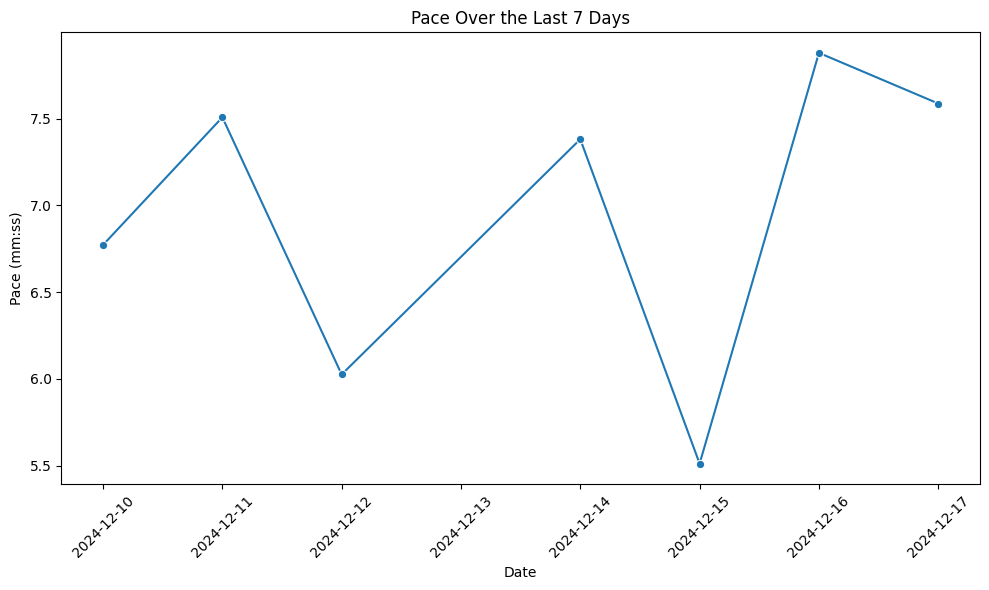

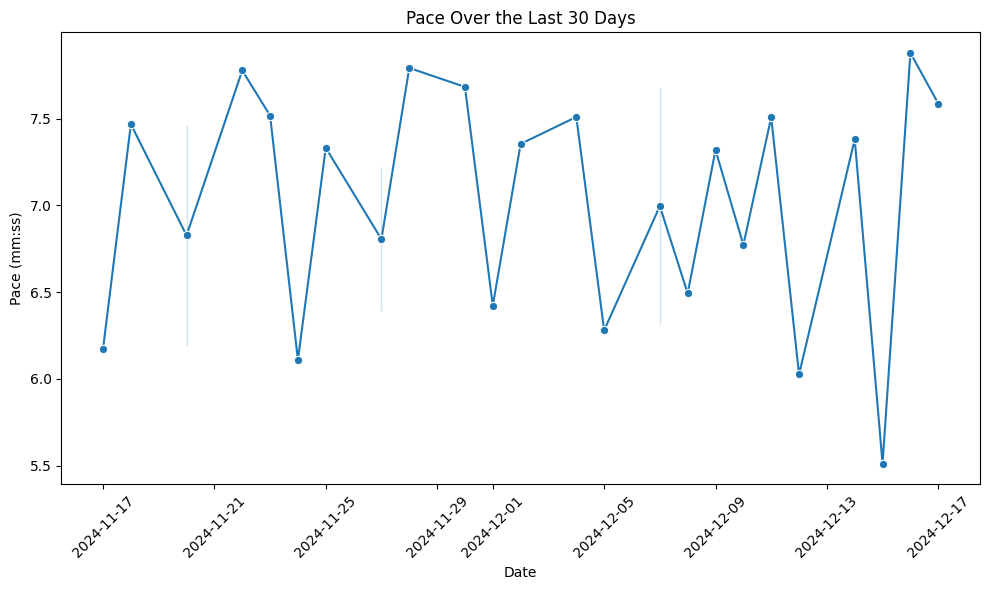

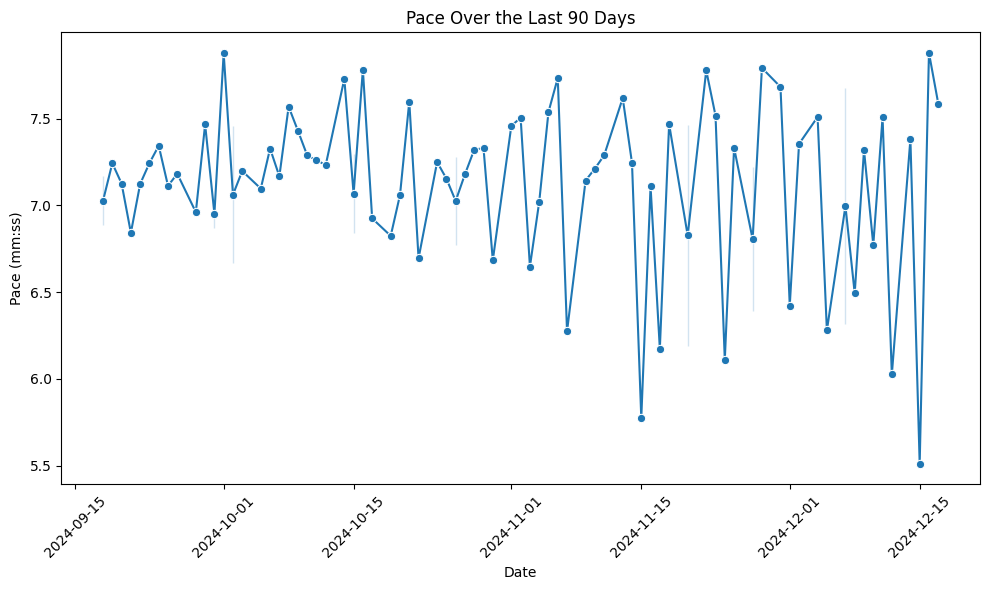

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# Ensure 'Date' is in datetime format and sort the DataFrame by date
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Get the most recent date in the DataFrame
most_recent_date = df['Date'].max()

# Function to filter data for the last X days
def filter_last_days(df, days):
    return df[df['Date'] >= most_recent_date - pd.Timedelta(days=days)]

# 1. Pace Over the Last 7 Days
last_7_days = filter_last_days(df, 7)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Pace (mph)', data=last_7_days, marker='o')
plt.title('Pace Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Pace (mm:ss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Pace Over the Last 30 Days
last_30_days = filter_last_days(df, 30)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Pace (mph)', data=last_30_days, marker='o')
plt.title('Pace Over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Pace (mm:ss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Pace Over the Last 90 Days
last_90_days = filter_last_days(df, 90)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Pace (mph)', data=last_90_days, marker='o')
plt.title('Pace Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Pace (mm:ss)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Filter entries with Pace (mph) below 5
# pace_below_5_mph = last_90_days[last_90_days['Pace (mph)'] < 5]

# # Print these entries
# print("Entries with a pace below 5 mph over the last 90 days:")
# print(pace_below_5_mph)


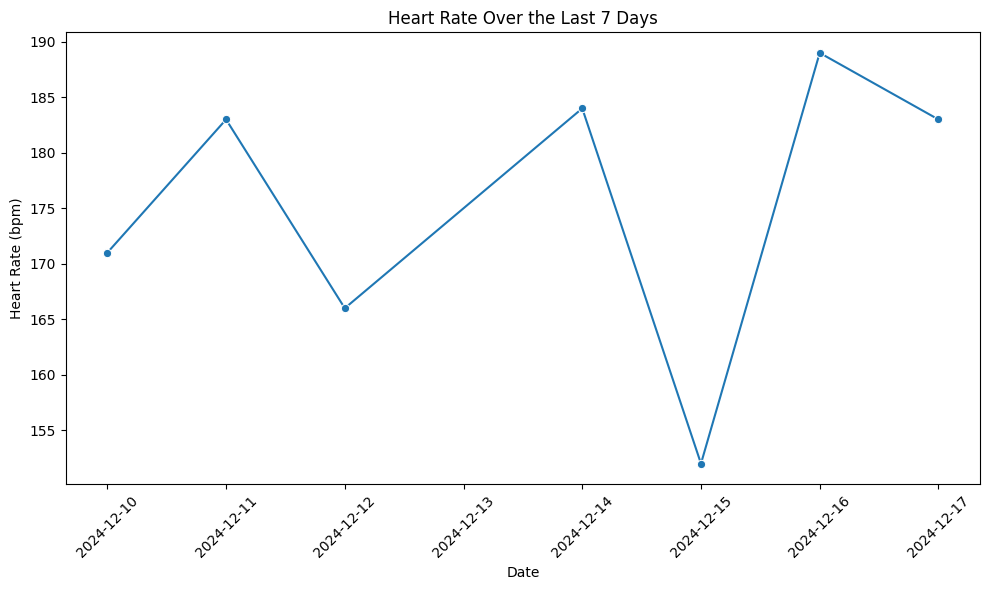

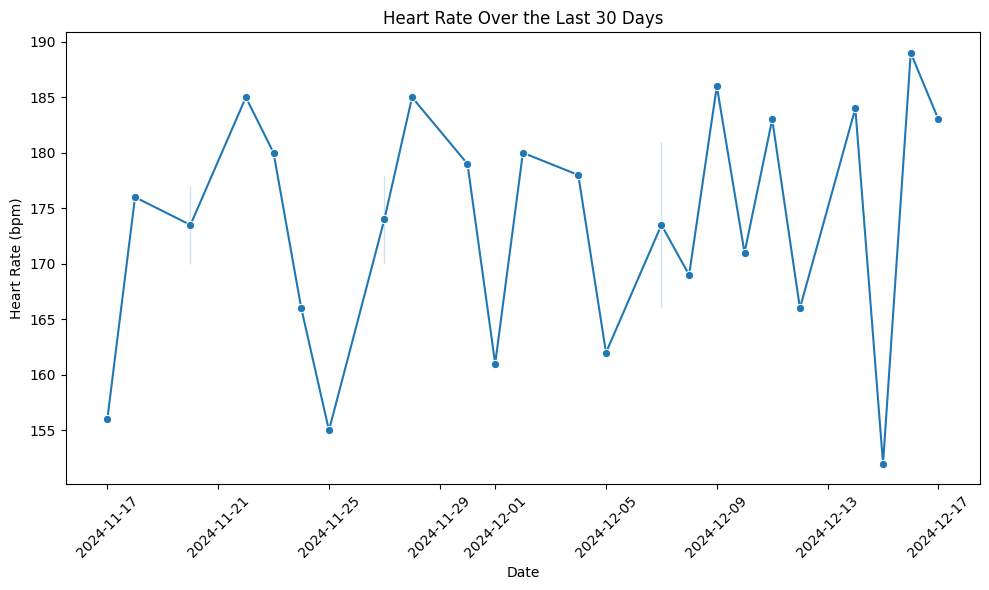

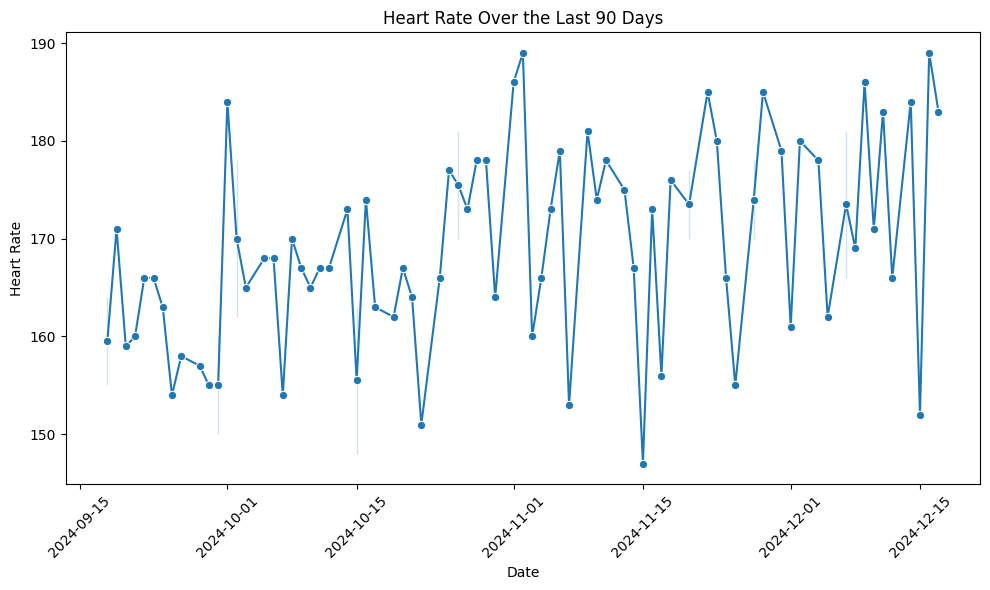

In [5]:
# 1. Heart Rate Over the Last 7 Days
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Heart Rate', data=last_7_days, marker='o')
plt.title('Heart Rate Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Heart Rate Over the Last 30 Days
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Heart Rate', data=last_30_days, marker='o')
plt.title('Heart Rate Over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Heart Rate', data=last_90_days, marker='o')
plt.title('Heart Rate Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Heart Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

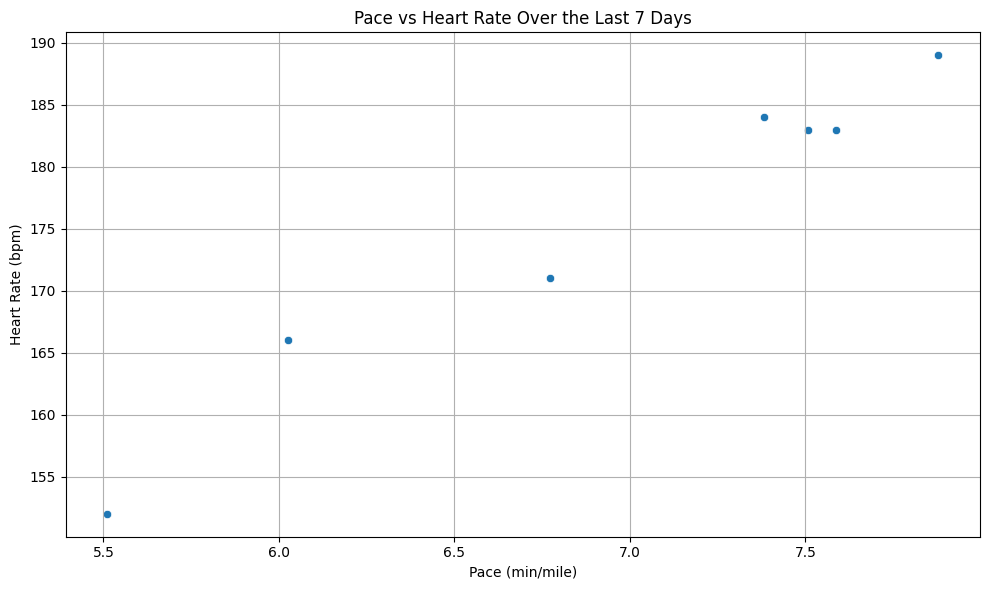

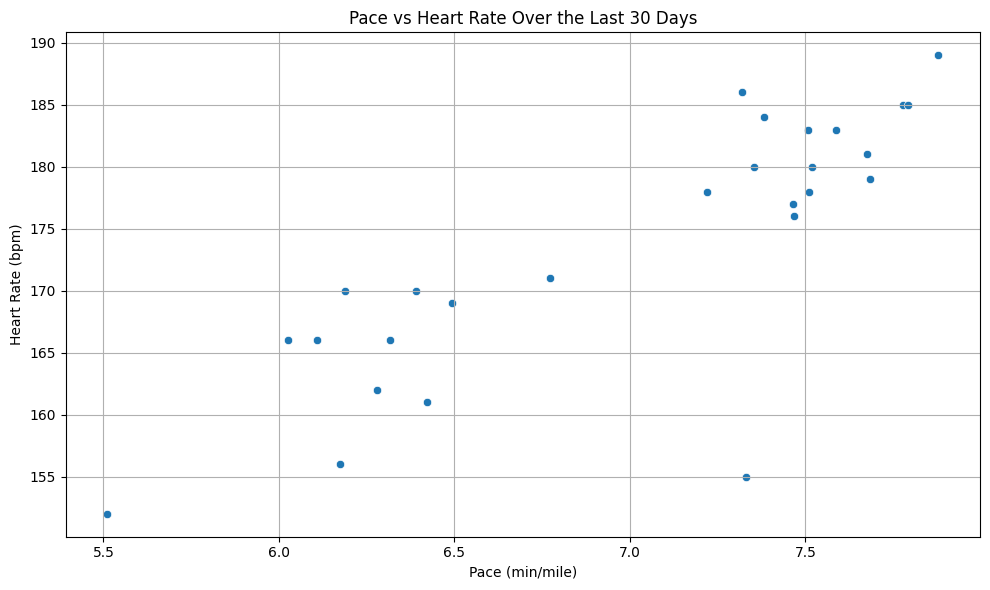

In [6]:
import matplotlib.pyplot as plt

# Scatter Plot: Pace vs Heart Rate for the Last 7 Days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_7_days)
plt.title('Pace vs Heart Rate Over the Last 7 Days')
plt.xlabel('Pace (min/mile)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter Plot: Pace vs Heart Rate for the Last 30 Days
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Pace (mph)', y='Heart Rate', data=last_30_days)
plt.title('Pace vs Heart Rate Over the Last 30 Days')
plt.xlabel('Pace (min/mile)')
plt.ylabel('Heart Rate (bpm)')
plt.grid(True)
plt.tight_layout()
plt.show() 


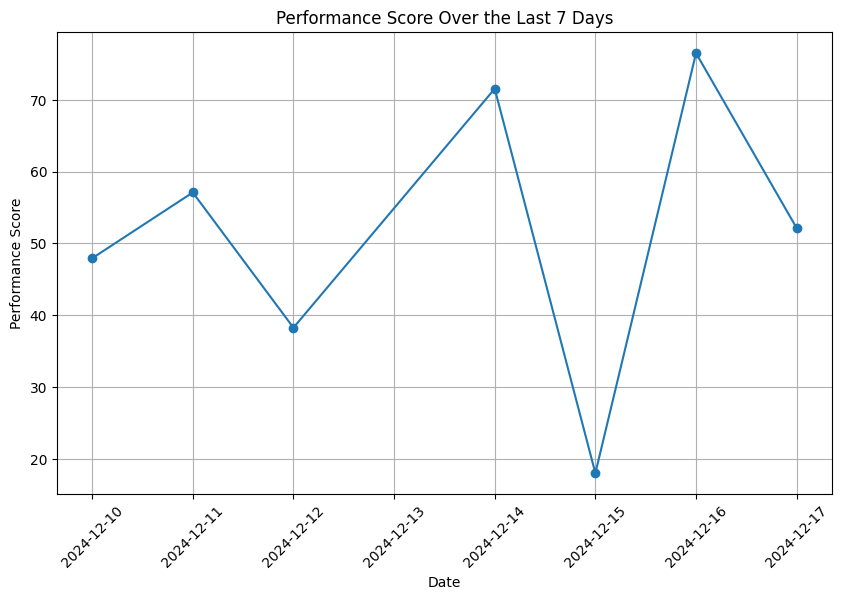

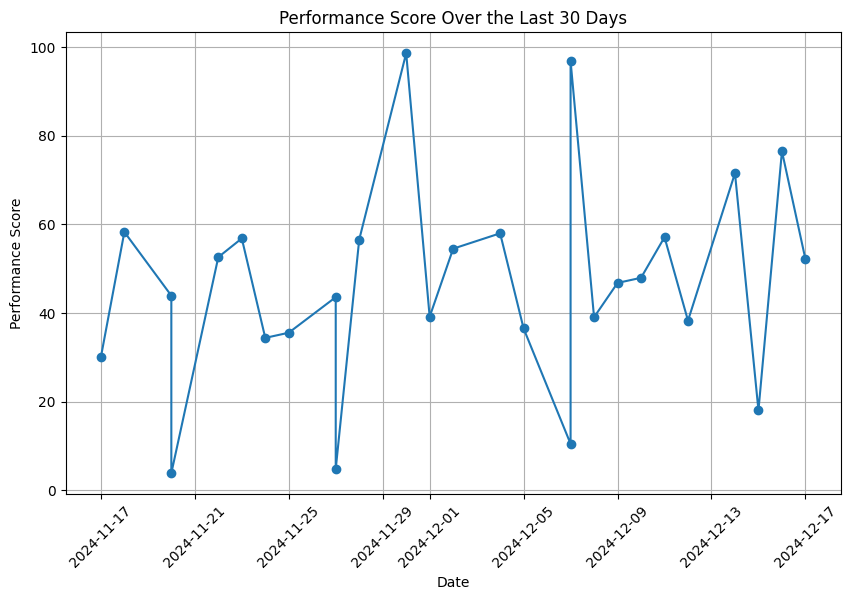

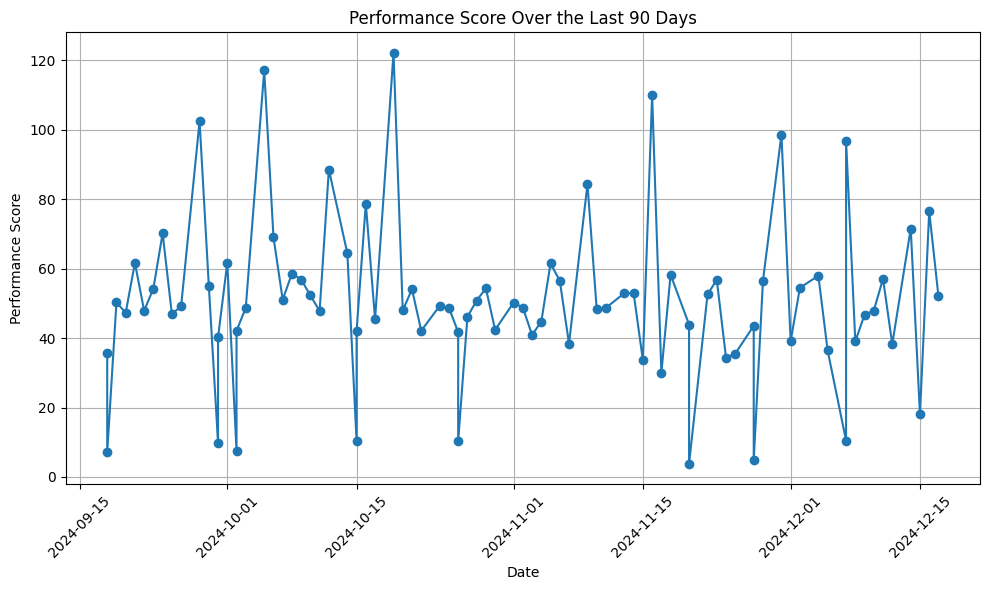

         Date                                     Title  Distance  Pace (mph)  \
52 2024-10-19                                  GINOBILI     20.01    6.824176   
65 2024-10-05                                 Get Lucky     18.01    7.096760   
27 2024-11-16                                     POWER     17.01    7.108893   
73 2024-09-28                                Psychotron     16.01    6.960870   
15 2024-11-30                                   Monster     13.30    7.682927   
9  2024-12-07                                      Peak     13.13    7.675869   
58 2024-10-12                   Give Life Back To Music     13.11    7.233103   
33 2024-11-09                   My Life in the Sunshine     13.11    7.143333   
54 2024-10-16  Err, like hop, I hopped out like wassup?     10.27    7.781941   
1  2024-12-16                                  Detached     10.00    7.879186   

    Heart Rate  Performance Score  
52         162         122.193886  
65         168         117.149035  


In [7]:
df = df[df['Distance'] >= 2.1]

df = df.reset_index(drop=True) 

# Adjusted performance score function to include distance
def calculate_performance_score(pace, heart_rate, distance):
    if pace == 0 or heart_rate == 0:
        return None  # Handle division by zero

   # Updated coefficients and exponents to emphasize pace
    performance_score = (
        (pace ** 1.9)         # Heavily reward faster paces
        * ((distance ** 1) / 1.3)   # Strongly reward longer distances
        / (heart_rate ** 0.31) # Minimally penalize higher heart rate
    )
    return performance_score

# Apply the performance score function to the past 7 days
last_7_days['Performance Score'] = last_7_days.apply(
    lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1)

# Plot the performance score for the past 7 days
plt.figure(figsize=(10, 6))
plt.plot(last_7_days['Date'], last_7_days['Performance Score'], marker='o')
plt.title('Performance Score Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Performance Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Apply the performance score function to the past 7 days
last_30_days['Performance Score'] = last_30_days.apply(
    lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1)

# Plot the performance score for the past 7 days
plt.figure(figsize=(10, 6))
plt.plot(last_30_days['Date'], last_30_days['Performance Score'], marker='o')
plt.title('Performance Score Over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Performance Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show() 


# Apply the performance score function to the past 7 days
last_90_days['Performance Score'] = last_90_days.apply(
    lambda row: calculate_performance_score(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1)

plt.figure(figsize=(10, 6))
plt.plot(last_90_days['Date'], last_90_days['Performance Score'], marker='o')
plt.title('Performance Score Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Performance Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Sort the last 90 days DataFrame by 'Performance Score' in descending order
top_10_performances = last_90_days.sort_values(by='Performance Score', ascending=False).head(10)

# Display the top 10 performances
print(top_10_performances[['Date', 'Title', 'Distance', 'Pace (mph)', 'Heart Rate', 'Performance Score']])


# pace_below_5_mph = last_7_days

# # Print these entries
# print("Entries with a pace below 5 mph over the last 90 days:")
# print(pace_below_5_mph)


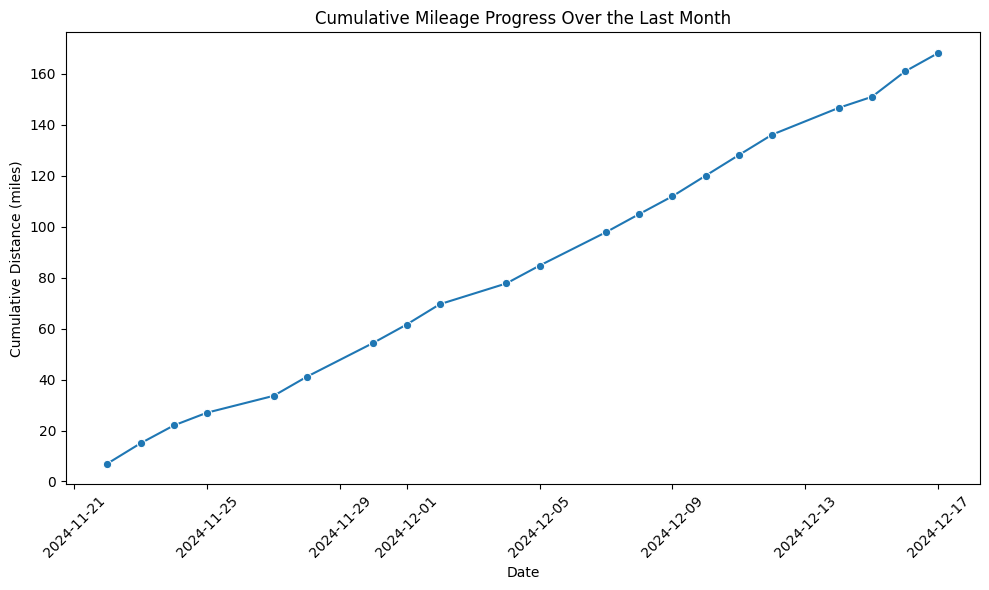

         Date  Distance  Cumulative Mileage
0  2024-11-22      7.00                7.00
1  2024-11-23      8.00               15.00
2  2024-11-24      7.00               22.00
3  2024-11-25      5.01               27.01
4  2024-11-27      6.60               33.61
5  2024-11-28      7.50               41.11
6  2024-11-30     13.30               54.41
7  2024-12-01      7.18               61.59
8  2024-12-02      8.00               69.59
9  2024-12-04      8.15               77.74
10 2024-12-05      7.00               84.74
11 2024-12-07     13.13               97.87
12 2024-12-08      7.12              104.99
13 2024-12-09      7.00              111.99
14 2024-12-10      8.10              120.09
15 2024-12-11      8.10              128.19
16 2024-12-12      8.00              136.19
17 2024-12-14     10.50              146.69
18 2024-12-15      4.34              151.03
19 2024-12-16     10.00              161.03
20 2024-12-17      7.25              168.28


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data for the past 3 months
three_months_ago = pd.to_datetime('today') - pd.DateOffset(months=1)
df_last_3_months = df[df['Date'] >= three_months_ago]

# Group by date and sum the distance for each day
daily_mileage = df_last_3_months.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage over the last 3 months
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.title('Cumulative Mileage Progress Over the Last Month')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, print the daily mileage data for review
print(daily_mileage)

/tmp/ipykernel_55810/3553686916.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_3_months['Year-Month'] = df_last_3_months['Date'].dt.to_period('M')
/tmp/ipykernel_55810/3553686916.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year-Month', y='Distance', data=monthly_mileage, palette='Blues_d')


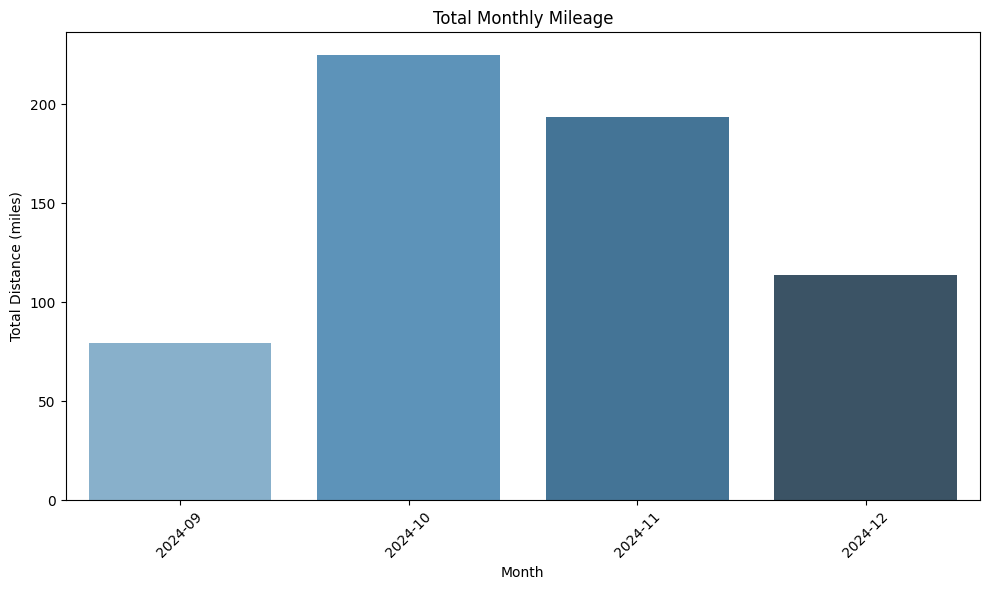

  Year-Month  Distance
0    2024-09     79.28
1    2024-10    225.06
2    2024-11    193.34
3    2024-12    113.87


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data for the past 3 months
three_months_ago = pd.to_datetime('today') - pd.DateOffset(months=3)  # Adjust to 3 months for monthly chart
df_last_3_months = df[df['Date'] >= three_months_ago]

# Extract the month and year from the 'Date' column
df_last_3_months['Year-Month'] = df_last_3_months['Date'].dt.to_period('M')

# Group by 'Year-Month' and sum the distance for each month
monthly_mileage = df_last_3_months.groupby('Year-Month')['Distance'].sum().reset_index()

# Sort by 'Year-Month'
monthly_mileage = monthly_mileage.sort_values('Year-Month')

# Plotting the monthly mileage bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Year-Month', y='Distance', data=monthly_mileage, palette='Blues_d')
plt.title('Total Monthly Mileage')
plt.xlabel('Month')
plt.ylabel('Total Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, print the monthly mileage data for review
print(monthly_mileage)


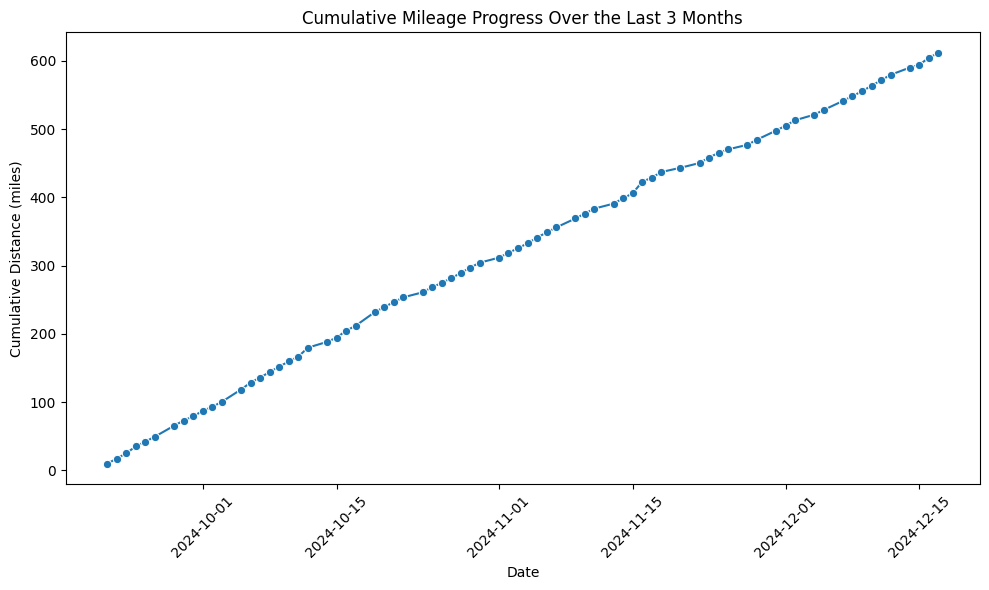

         Date  Distance  Cumulative Mileage
0  2024-09-21     10.01               10.01
1  2024-09-22      7.28               17.29
2  2024-09-23      8.00               25.29
3  2024-09-24     10.02               35.31
4  2024-09-25      7.00               42.31
..        ...       ...                 ...
68 2024-12-12      8.00              579.46
69 2024-12-14     10.50              589.96
70 2024-12-15      4.34              594.30
71 2024-12-16     10.00              604.30
72 2024-12-17      7.25              611.55

[73 rows x 3 columns]


In [10]:
# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data for the past 3 months
three_months_ago = pd.to_datetime('today') - pd.DateOffset(months=3)
df_last_3_months = df[df['Date'] >= three_months_ago]

# Group by date and sum the distance for each day
daily_mileage = df_last_3_months.groupby('Date')['Distance'].sum().reset_index()

# Sort by date
daily_mileage = daily_mileage.sort_values('Date')

# Create a cumulative sum of the mileage
daily_mileage['Cumulative Mileage'] = daily_mileage['Distance'].cumsum()

# Plotting the cumulative mileage over the last 3 months
plt.figure(figsize=(10, 6))
sns.lineplot(x='Date', y='Cumulative Mileage', data=daily_mileage, marker='o')
plt.title('Cumulative Mileage Progress Over the Last 3 Months')
plt.xlabel('Date')
plt.ylabel('Cumulative Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, print the daily mileage data for review
print(daily_mileage)

/tmp/ipykernel_55810/2475535646.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months.loc[:, 'Year-Month'] = df_last_6_months['Date'].dt.to_period('M')


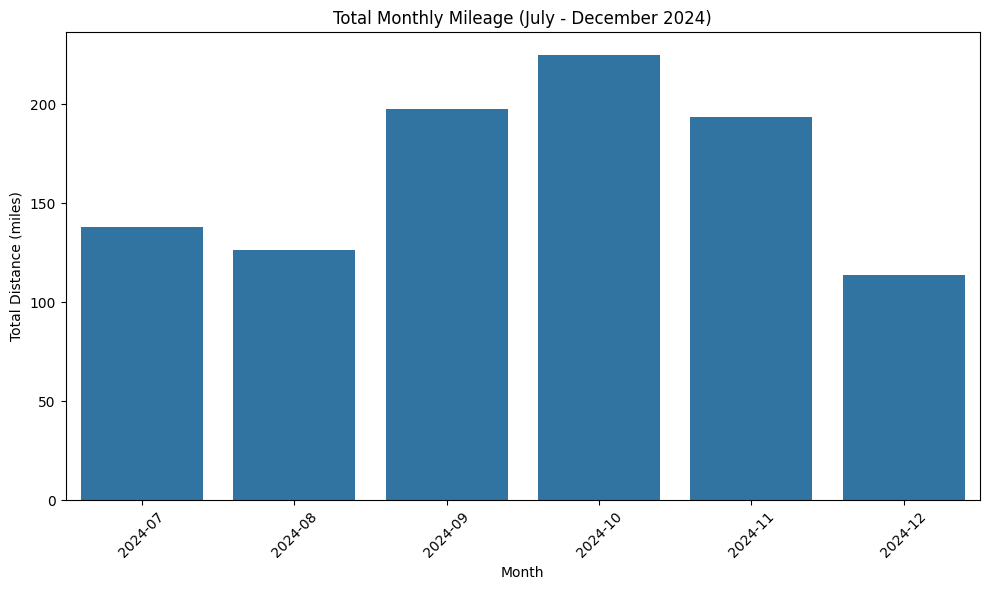

  Year-Month  Distance
0    2024-07    137.88
1    2024-08    126.57
2    2024-09    197.72
3    2024-10    225.06
4    2024-11    193.34
5    2024-12    113.87


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and 'Date' is in datetime format, and 'Distance' is in numeric format

# Ensure 'Distance' is in numeric format
df['Distance'] = pd.to_numeric(df['Distance'], errors='coerce')

# Drop rows with missing 'Distance' or 'Date' values
df = df.dropna(subset=['Distance', 'Date'])

# Filter data for the past 6 months, starting from July 1st
start_of_july = pd.to_datetime('2024-07-01')  # Set the start date to July 1st, 2024
df_last_6_months = df[df['Date'] >= start_of_july]

# Use .loc to avoid SettingWithCopyWarning
df_last_6_months.loc[:, 'Year-Month'] = df_last_6_months['Date'].dt.to_period('M')

# Group by 'Year-Month' and sum the distance for each month
monthly_mileage = df_last_6_months.groupby('Year-Month')['Distance'].sum().reset_index()

# Sort by 'Year-Month'
monthly_mileage = monthly_mileage.sort_values('Year-Month')

# Plotting the monthly mileage bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Year-Month', y='Distance', data=monthly_mileage)
plt.title('Total Monthly Mileage (July - December 2024)')
plt.xlabel('Month')
plt.ylabel('Total Distance (miles)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optionally, print the monthly mileage data for review
print(monthly_mileage)


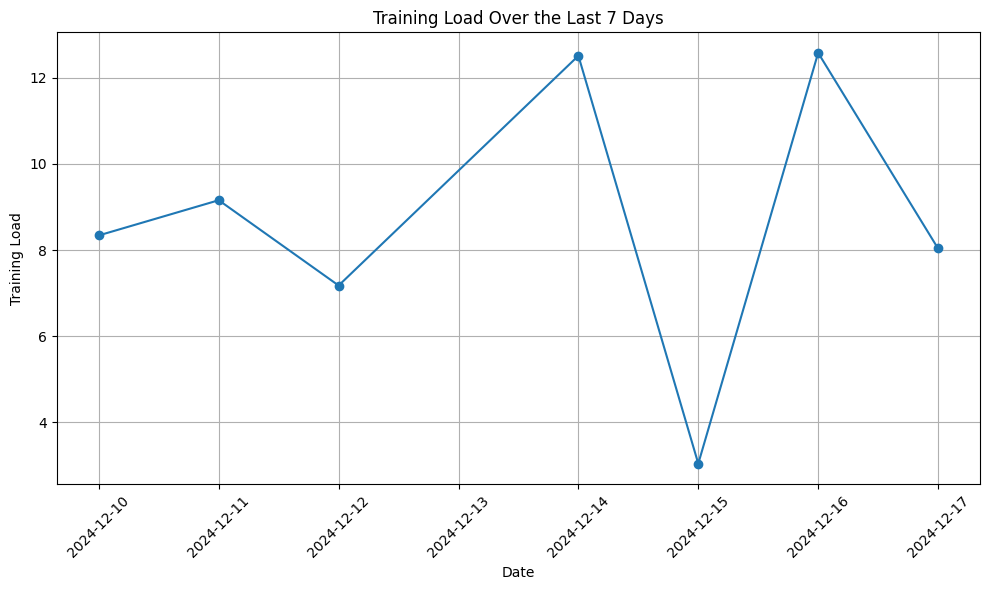

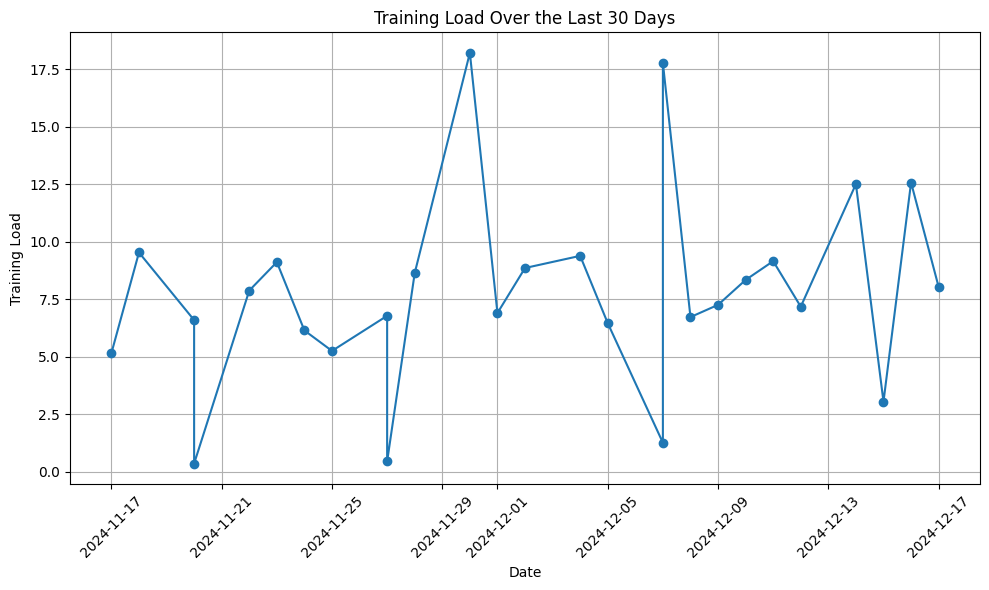

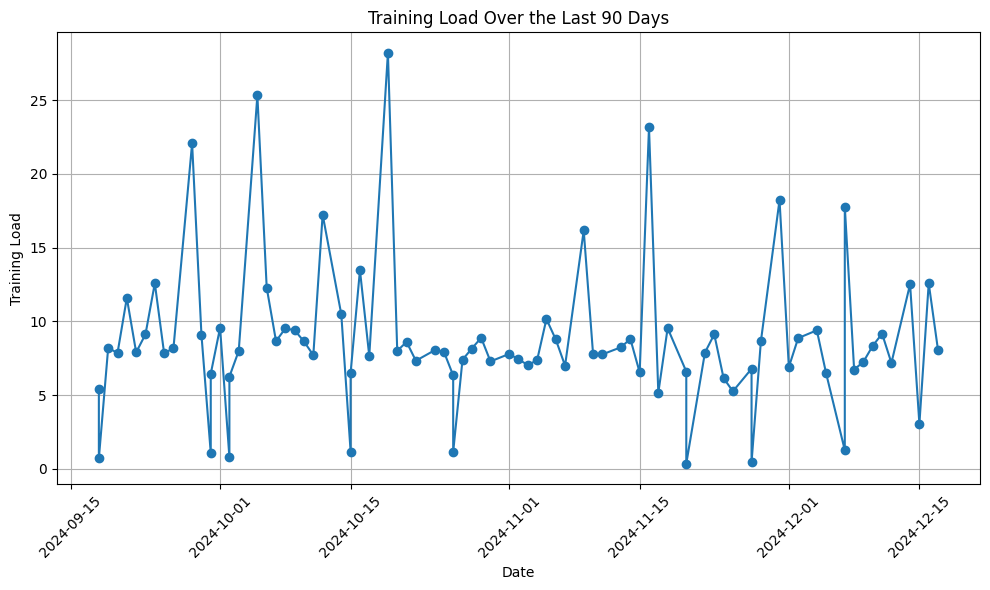

Entries with training load less than 5 over the last 90 days:
         Date          Title  Distance  Pace (mph)  Heart Rate  Training Load
82 2024-09-18    Morning Run      1.14    6.885906         155       0.706524
70 2024-09-30      Gettin it      1.55    6.871921         150       1.071465
67 2024-10-02  Afternoon Run      1.30    6.666667         162       0.782526
56 2024-10-15        warm up      1.64    6.841251         148       1.155623
45 2024-10-26        Drained      1.75    6.774194         170       1.142339
23 2024-11-20             cd      0.77    6.187500         170       0.349252
17 2024-11-27             cd      0.90    6.390533         170       0.446112
10 2024-12-07      Shake Out      2.00    6.315789         166       1.258433
2  2024-12-15           Sore      4.34    5.511111         152       3.042576
Entries with training load less than 5 over the last 90 days:
         Date                    Title  Distance  Pace (mph)  Heart Rate  \
73 2024-09-28       

In [12]:
def calculate_training_load(pace, heart_rate, distance):
    if pace == 0 or heart_rate == 0 or distance == 0:
        return None  # Handle division by zero or invalid values
    
    # Adjusted coefficients and exponents to emphasize distance and pace more
    training_load = (
        (distance ** 1.3)          # Heavily reward longer distances (increased emphasis)
        * (pace ** 1.3)            # Reward faster paces (moderate emphasis)
        / (heart_rate ** 0.6)      # Penalize higher heart rate (lower effort = lower load)
    )
    return training_load

# Apply the training load function to the past 7 days
last_7_days['Training Load'] = last_7_days.apply(
    lambda row: calculate_training_load(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1)

# Plot the training load for the past 7 days
plt.figure(figsize=(10, 6))
plt.plot(last_7_days['Date'], last_7_days['Training Load'], marker='o')
plt.title('Training Load Over the Last 7 Days')
plt.xlabel('Date')
plt.ylabel('Training Load')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply the training load function to the past 30 days
last_30_days['Training Load'] = last_30_days.apply(
    lambda row: calculate_training_load(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1)

# Plot the training load for the past 30 days
plt.figure(figsize=(10, 6))
plt.plot(last_30_days['Date'], last_30_days['Training Load'], marker='o')
plt.title('Training Load Over the Last 30 Days')
plt.xlabel('Date')
plt.ylabel('Training Load')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Apply the training load function to the past 90 days
last_90_days['Training Load'] = last_90_days.apply(
    lambda row: calculate_training_load(row['Pace (mph)'], row['Heart Rate'], row['Distance']), axis=1)

# Plot the training load for the past 90 days
plt.figure(figsize=(10, 6))
plt.plot(last_90_days['Date'], last_90_days['Training Load'], marker='o')
plt.title('Training Load Over the Last 90 Days')
plt.xlabel('Date')
plt.ylabel('Training Load')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


low_training_load_threshold = 5  

# Filter entries with training load less than 5 for the past 90 days
low_training_load_90_days = last_90_days[last_90_days['Training Load'] < low_training_load_threshold]

# Print these entries
print("Entries with training load less than 5 over the last 90 days:")
print(low_training_load_90_days[['Date', 'Title', 'Distance', 'Pace (mph)', 'Heart Rate', 'Training Load']])

high_training_load_threshold = 15  

# Filter entries with training load greater than 15 for the past 90 days
low_training_load_90_days = last_90_days[last_90_days['Training Load'] > high_training_load_threshold]

# Print these entries
print("Entries with training load less than 5 over the last 90 days:")
print(low_training_load_90_days[['Date', 'Title', 'Distance', 'Pace (mph)', 'Heart Rate', 'Training Load']])


## Training Stress Score (TSS)
The TSS is a score used to quantify the intensity and duration of a workout, taking into account both the duration and the intensity of the workout. The formula for TSS is:

𝑇𝑆𝑆 = (Duration × Intensity Factor (IF) / FTP) × 100

Where:

Duration is the time of the workout (in hours or minutes).

Intensity Factor (IF) is calculated as the ratio of normalized power to functional threshold power (FTP) or normalized pace to threshold pace.

FTP is your Functional Threshold Power or your threshold pace. If you're a runner, FTP could be your threshold pace (pace at which you can run for about an hour).

## Acute Training Load (ATL) and Chronic Training Load (CTL)
These values measure the impact of your recent and long-term training loads.

ATL (Acute Training Load): This is the 7-day rolling average of TSS. It gives an idea of how hard your recent workouts have been.

CTL (Chronic Training Load): This is the 28-day rolling average of TSS, reflecting your long-term fitness and how consistent your training has been.

/tmp/ipykernel_55810/3148209556.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Duration'] = df_last_6_months['Distance'] / df_last_6_months['Pace (mph)']
/tmp/ipykernel_55810/3148209556.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['TSS'] = df_last_6_months.apply(lambda row: calculate_tss(row['Distance'], row['Pace (mph)'], row['Duration'], threshold_pace), axis=1)
/tmp/ipykernel_55810/3148209556.py:22: SettingWithCopyWarning: 
A value is trying to be set on a

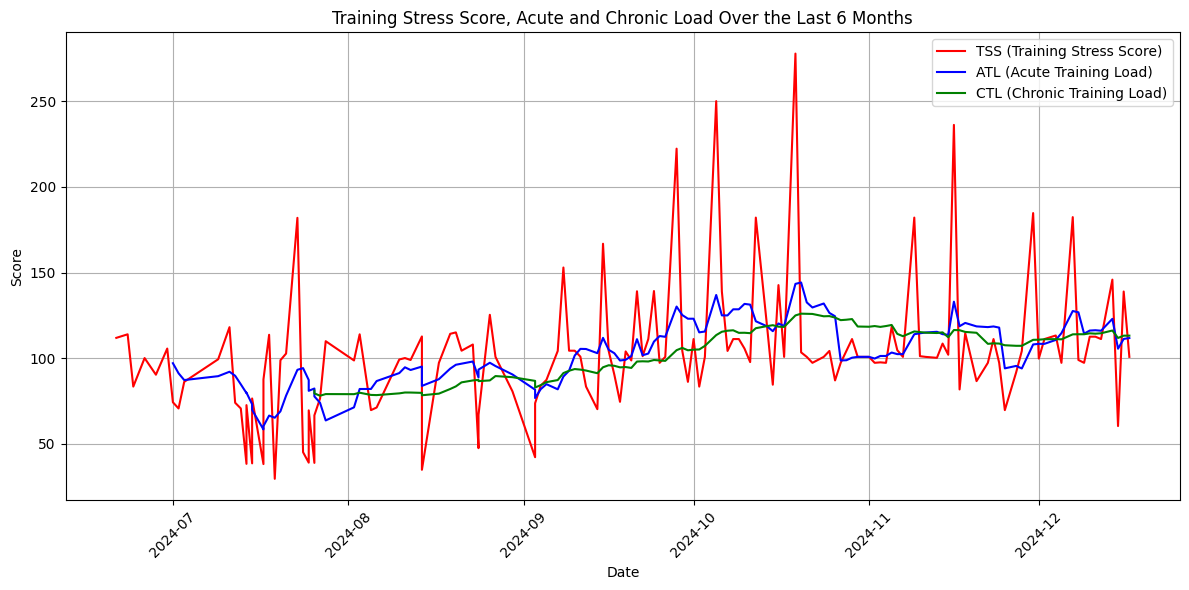

          Date         TSS         ATL         CTL
165 2024-12-12  111.111111  115.972222  114.489087
166 2024-12-14  145.833333  122.916667  116.101190
167 2024-12-15   60.277778  105.476190  111.750992
168 2024-12-16  138.888889  111.190476  113.100198
169 2024-12-17  100.694444  111.686508  113.100198


In [13]:
# Assuming you already have a dataframe df with 'Date', 'Distance', 'Pace (mph)', 'Heart Rate'
# You can add your threshold pace value (FTP) here
threshold_pace = 7.2  # e.g., threshold pace of 6 mph (adjust according to your actual pace)

# Filter the data to include only the last 6 months
six_months_ago = pd.to_datetime('today') - pd.DateOffset(months=6)
df_last_6_months = df[df['Date'] >= six_months_ago]

# Function to calculate TSS (Training Stress Score)
def calculate_tss(distance, pace, duration, threshold_pace):
    intensity_factor = pace / threshold_pace  # Calculate intensity factor based on pace
    tss = (duration * intensity_factor) * 100  # TSS formula
    return tss

# Calculate Duration (time in hours) for each row in the dataframe
df_last_6_months['Duration'] = df_last_6_months['Distance'] / df_last_6_months['Pace (mph)']

# Calculate TSS for each run
df_last_6_months['TSS'] = df_last_6_months.apply(lambda row: calculate_tss(row['Distance'], row['Pace (mph)'], row['Duration'], threshold_pace), axis=1)

# Calculate the 7-day (ATL) and 28-day (CTL) rolling averages of TSS
df_last_6_months['ATL'] = df_last_6_months['TSS'].rolling(window=7).mean()
df_last_6_months['CTL'] = df_last_6_months['TSS'].rolling(window=28).mean()

# Plot the TSS, ATL, and CTL over time for the last 6 months
plt.figure(figsize=(12, 6))

plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS (Training Stress Score)', color='red')
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL'], label='ATL (Acute Training Load)', color='blue')
plt.plot(df_last_6_months['Date'], df_last_6_months['CTL'], label='CTL (Chronic Training Load)', color='green')

plt.title('Training Stress Score, Acute and Chronic Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

# Optionally, print the TSS, ATL, and CTL for review
print(df_last_6_months[['Date', 'TSS', 'ATL', 'CTL']].tail())

/tmp/ipykernel_55810/1292237650.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Cumulative TL'] = df_last_6_months['TSS'].cumsum()


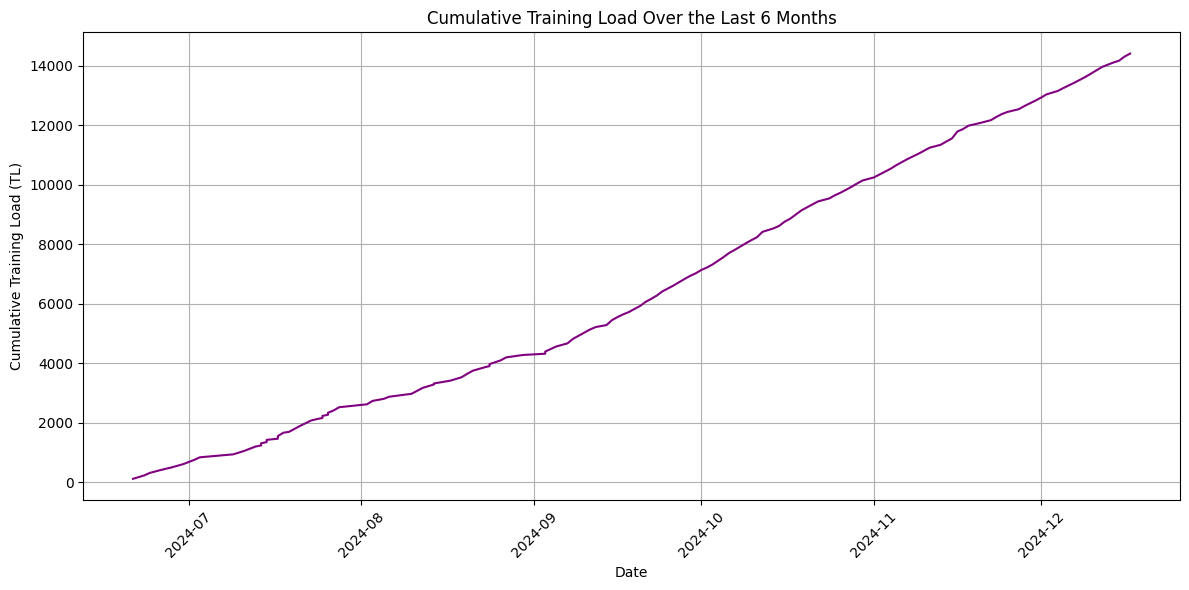

In [14]:
# Calculate cumulative training load (sum of TSS values)
df_last_6_months['Cumulative TL'] = df_last_6_months['TSS'].cumsum()

# Plot Cumulative Training Load
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Cumulative TL'], label='Cumulative Training Load', color='purple')
plt.title('Cumulative Training Load Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Cumulative Training Load (TL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Intensity Factor (IF):
Intensity factor is used to express the intensity of a workout relative to your threshold. It can be a more specific measure of how hard the workout was in relation to your capability. For running, it's typically calculated as:

𝐼𝐹 = Actual Pace / Threshold Pace
​
This could give you a clear view of how much you are pushing yourself in relation to your usual running capability.

/tmp/ipykernel_55810/3364448182.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Intensity Factor'] = df_last_6_months['Pace (mph)'] / threshold_pace


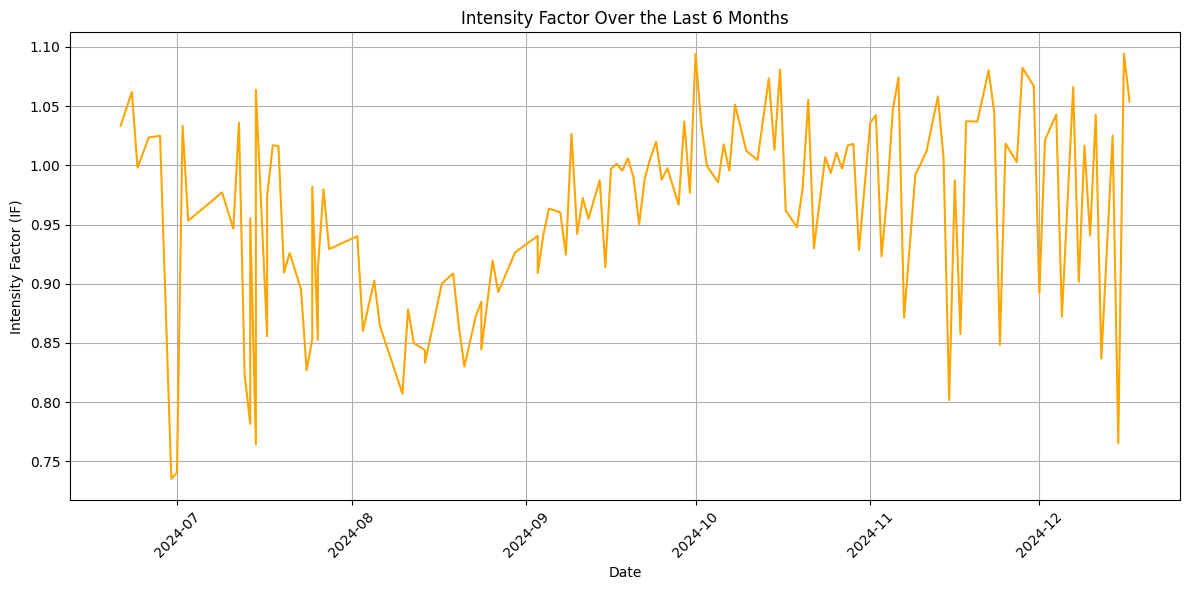

In [15]:
threshold_pace = 7.2

# Calculate Intensity Factor (IF)
df_last_6_months['Intensity Factor'] = df_last_6_months['Pace (mph)'] / threshold_pace

# Plot IF over time
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Intensity Factor'], label='Intensity Factor (IF)', color='orange')
plt.title('Intensity Factor Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Intensity Factor (IF)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Acute vs Chronic Load Comparison: 
You can plot a difference between Acute Load (ATL) and Chronic Load (CTL) over time to identify periods of overtraining or recovery needs. If ATL significantly exceeds CTL, it might indicate that you are pushing yourself too hard recently.

/tmp/ipykernel_55810/2503842443.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['ATL - CTL Difference'] = df_last_6_months['ATL'] - df_last_6_months['CTL']


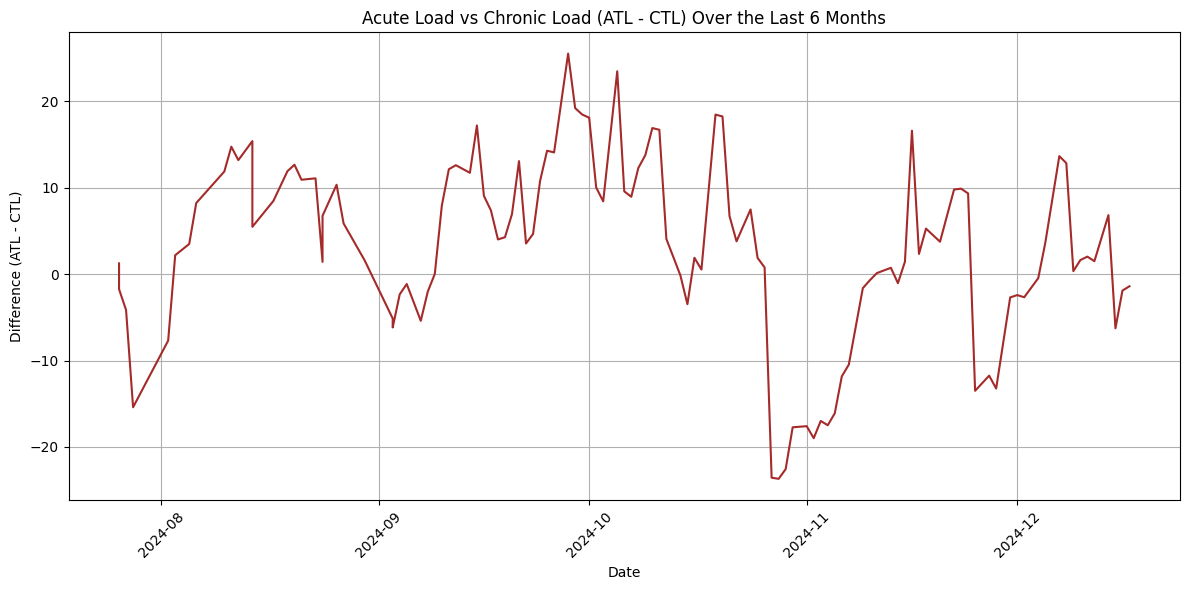

In [16]:
# Calculate ATL - CTL difference
df_last_6_months['ATL - CTL Difference'] = df_last_6_months['ATL'] - df_last_6_months['CTL']

# Plot ATL vs CTL difference
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['ATL - CTL Difference'], label='ATL - CTL Difference', color='brown')
plt.title('Acute Load vs Chronic Load (ATL - CTL) Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Difference (ATL - CTL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


## Training Peaks: 
Peaks will help you spot high-intensity sessions that may require more recovery.

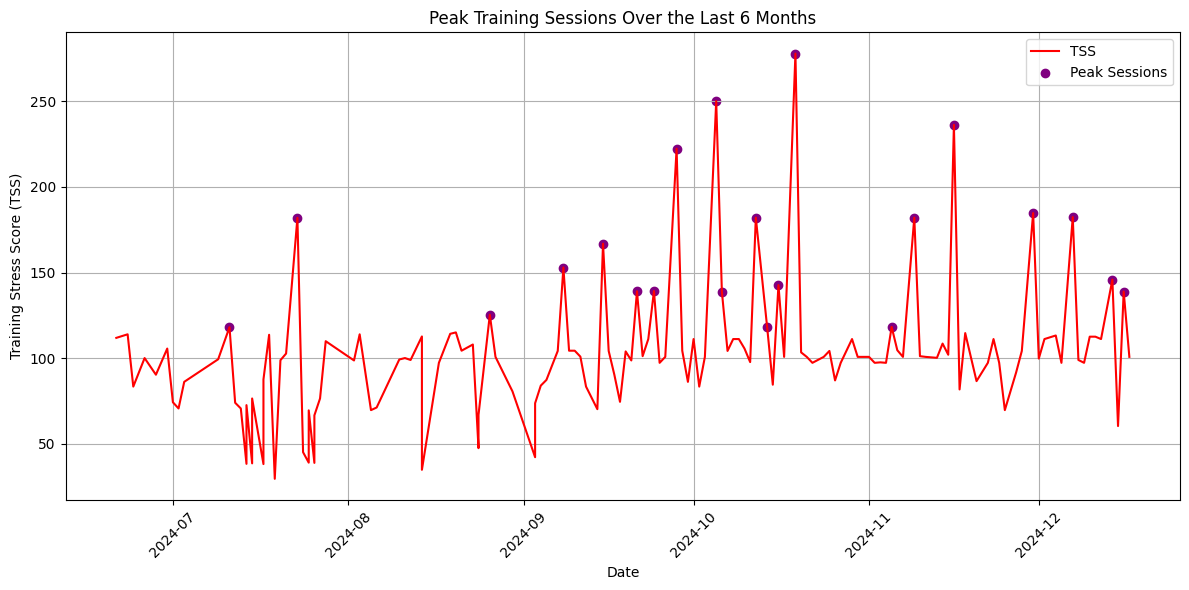

          Date                                     Title         TSS  \
40  2024-07-11                       I’m so fucking back  118.055556   
53  2024-07-23                                  Ahh shit  181.944444   
77  2024-08-26                                 intervals  125.277778   
85  2024-09-08                                  Long Run  152.916667   
91  2024-09-15                                  Long run  166.805556   
97  2024-09-21                                  Long Run  139.027778   
100 2024-09-24                            I got the worm  139.166667   
103 2024-09-28                                Psychotron  222.361111   
109 2024-10-05                                 Get Lucky  250.138889   
110 2024-10-06                    Foreclosure of A Dream  138.888889   
116 2024-10-12                   Give Life Back To Music  182.083333   
117 2024-10-14                                  SMUCKERS  118.055556   
119 2024-10-16  Err, like hop, I hopped out like wassup?  142.63

In [17]:
# Define a threshold for peak training sessions (e.g., TSS > 100)
peak_sessions = df_last_6_months[df_last_6_months['TSS'] > 115]

# Plot peak sessions
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['TSS'], label='TSS', color='red')
plt.scatter(peak_sessions['Date'], peak_sessions['TSS'], color='purple', label='Peak Sessions')
plt.title('Peak Training Sessions Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Training Stress Score (TSS)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

print(peak_sessions[['Date', 'Title','TSS', 'Distance', 'Pace (mph)', 'Heart Rate']])

## Stress/Rest Ratio
This can be calculated as the ratio of the acute load (ATL) to chronic load (CTL). It provides an indication of how well-balanced your training and recovery are. A high ATL/CTL ratio might indicate you're not recovering enough and could be at risk for overtraining.

/tmp/ipykernel_55810/593534801.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_6_months['Stress/Rest Ratio'] = df_last_6_months['ATL'] / df_last_6_months['CTL']


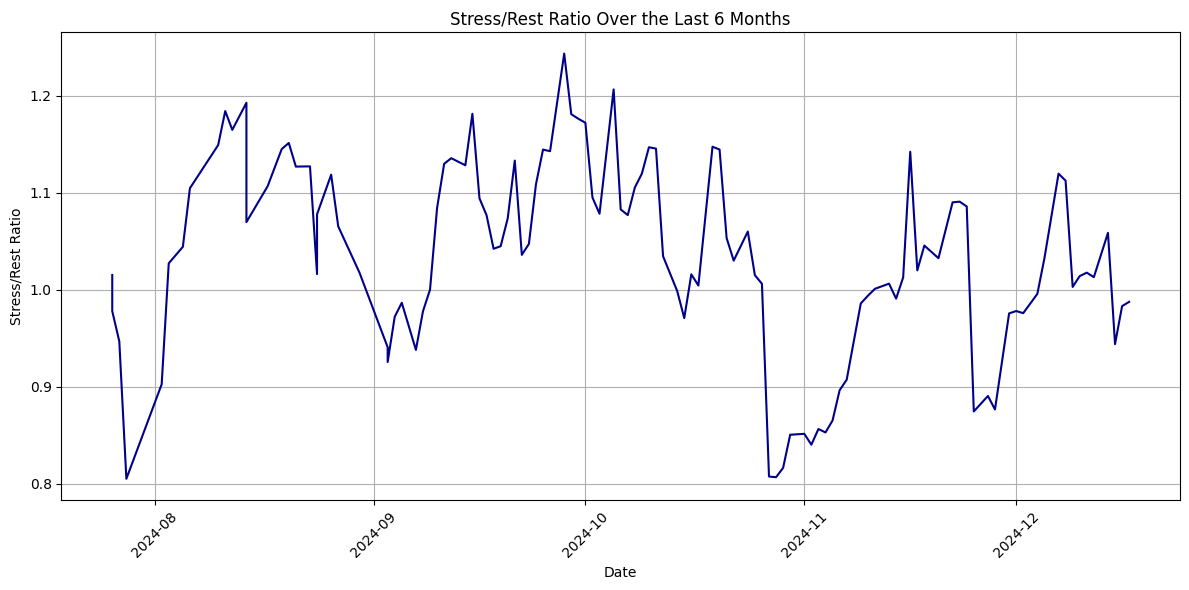

In [18]:
# Calculate Stress/Rest ratio
df_last_6_months['Stress/Rest Ratio'] = df_last_6_months['ATL'] / df_last_6_months['CTL']

# Plot Stress/Rest Ratio
plt.figure(figsize=(12, 6))
plt.plot(df_last_6_months['Date'], df_last_6_months['Stress/Rest Ratio'], label='Stress/Rest Ratio', color='darkblue')
plt.title('Stress/Rest Ratio Over the Last 6 Months')
plt.xlabel('Date')
plt.ylabel('Stress/Rest Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
